# 0. Preparation

In [3]:
if 'google.colab' in str(get_ipython()):
    IN_COLLAB = True
else:
    IN_COLLAB = False

if IN_COLLAB:
    #TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
    MY_HOME_ABS_PATH = "/content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling"
    from google.colab import drive
    drive.mount('/content/drive/')
else:
    MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling/"

## Import libraries

In [4]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import copy
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pytorch_lightning as pl
import torch
import torch.nn as nn

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import BaseModel, MAE
from pytorch_forecasting.metrics.point import RMSE
from pytorch_forecasting.data.encoders import NaNLabelEncoder

from sklearn.metrics import r2_score
from timeit import default_timer
from tqdm import tqdm
from datetime import datetime
import gc
import pickle

# Load locale custome modules
os.chdir(MY_HOME_ABS_PATH)
if IN_COLLAB:
     sys.path.insert(0,os.path.abspath("./code/src/tools"))
else:
    sys.path.append('./.cred')
    sys.path.append('./code/src/tools')
    sys.path.append(os.path.abspath("./code/src/tools"))

from CloudIO.AzStorageClient import AzStorageClient
from data_pipeline_lib import *
from model_pipeline_lib import *

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pl.seed_everything(42)
plt.rcParams['figure.figsize'] = [6, 3]

2023-04-08 01:51:57.487042: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-08 01:51:57.533887: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-08 01:51:57.534693: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 01:51:58.261804: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Global seed set to 42
Global seed set to 42


In [12]:
def setup_tsdataset_nogpp(train_df, val_df, test_df, min_encoder_len):
    # create training and validation TS dataset 
    training = TimeSeriesDataSet(
      train_df, # <------ no longer subsetting, option 1 split can use entire train site sequence
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False, # <---- turned on bc some rows are removed.
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["MODIS_IGBP","koppen_main","koppen_sub"],
      static_reals=[],
      time_varying_known_categoricals=['year', 'month', 'day', 'hour'],
      time_varying_known_reals=["timestep_idx_global", 
                                'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 
                                'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily', 'PET', 'Ts', 
                                'ESACCI-sm', 'NDWI', 'Percent_Snow', 'Fpar', 'Lai', 'LST_Day','LST_Night'],
      time_varying_unknown_categoricals=["gap_flag_month", "gap_flag_hour"], 
      time_varying_unknown_reals=[],
      target_normalizer=None,
      categorical_encoders={'MODIS_IGBP': NaNLabelEncoder(add_nan=True),
                            'koppen_main': NaNLabelEncoder(add_nan=True),
                            'koppen_sub': NaNLabelEncoder(add_nan=True),
                            'year': NaNLabelEncoder(add_nan=True),
                            },
      add_relative_time_idx=True,
      add_target_scales=False, # <------- turned off
      add_encoder_length=False, # <------- turned off
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)


def get_preds_actuals_agg(dataloader):
    # Get preds for site
    preds_q = best_tft.predict(dataloader, mode="quantiles", return_x=False)
    
    # Get actuals and mask from dataloader
    actuals_list = []
    mask_list = []
    for x, y in iter(dataloader):
        actuals_list.append(y[0])
        mask_list.append(x['x_cat'][-1, -1].reshape(-1))
    actuals = torch.cat(actuals_list)
    mask = torch.logical_not(torch.cat(mask_list))

    # Reshape
    actuals = actuals.reshape(-1)
    
    return preds_q, actuals, mask


def get_eval_metrics_simple(y_true, y_pred, mask=None):    
    # Apply mask if there is any
    if mask is not None:            
        y_true = y_true[mask.bool()]
        y_pred = y_pred[mask.bool()]

    rmse = torch.sqrt(torch.mean((y_true - y_pred) ** 2)).item()
    mae = torch.mean((y_true - y_pred).abs()).item()
    nse = nash_sutcliffe(y_true, y_pred).item()
    
    return rmse, mae, nse

# Load data from Azure blob

In [13]:
root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + '.tmp'
model_dir = root_dir + os.sep + 'data' + os.sep + 'models'
cred_dir = root_dir + os.sep + '.cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'

# Download full data
container = "all-sites-data"
blob_name = "full_2010_2015_v_mvp_raw.parquet"

data_df = get_raw_datasets(container, blob_name)

Data size: (4862712, 51)
Data Columns: Index(['GPP_NT_VUT_REF', 'site_id', 'timestep_idx_local',
       'timestep_idx_global', 'datetime', 'date', 'year', 'month', 'day',
       'hour', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA',
       'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
       'b7', 'IGBP', 'lat', 'long', 'koppen_sub', 'koppen_main', 'c3c4',
       'c4_percent', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily',
       'PET', 'Ts', 'ESACCI-sm', 'MODIS_LC', 'NDWI', 'Percent_Snow', 'Fpar',
       'Lai', 'LST_Day', 'LST_Night', 'MODIS_IGBP', 'MODIS_PFT',
       'gap_flag_hour', 'gap_flag_month'],
      dtype='object')
NA count: 0


# Define Constants, Functions

In [14]:
# Select split to evaluate
eval_split = 'val'

## Run Eval Loop

In [15]:
# Load best models
print(f"\n\n-------- BEGIN ROUND: --------")
model_dir = "tft_model_1YrTrain_3DEncode_BigNetwork_NoGPP_230326_1948"
exp_model_dir = f"/root/co2-flux-hourly-gpp-modeling/data/models/{model_dir}"
checkpt_dir = f"{exp_model_dir}/lightning_logs/version_0/checkpoints/"
checkpt = os.listdir(checkpt_dir)[-1]
best_model_path = f"{checkpt_dir}{checkpt}"
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

# Experiment constants
VAL_INDEX  = 3
TEST_INDEX = 4
SUBSET_LEN = 24*365
ENCODER_LEN = 24*3
print(f"Training timestemp length = {SUBSET_LEN}.")

# create dataloaders for model
batch_size = 256 
cpu_count = os.cpu_count()

# Setup dataset
train_df, val_df, test_df = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
train_df, val_df, test_df = subset_data(train_df, val_df, test_df, SUBSET_LEN)
train, validation, test = setup_tsdataset_nogpp(train_df, val_df, test_df, ENCODER_LEN)

# Select split to evaluate
if eval_split == 'val':
    dataloader = validation
    split_df = val_df.copy()
elif eval_split == 'test':
    dataloader = test
    split_df = test_df.copy()

# Load or get quantile preds, mask, actuals  
try:
    print("Loading quantile preds, actuals and mask from previous eval script")
    with open(exp_model_dir + os.sep + f"{eval_split}_actuals.pkl", "rb") as fin:
        actuals_agg = pickle.load(fin)

    with open(exp_model_dir + os.sep + f"{eval_split}_mask.pkl", "rb") as fin:
        mask_agg = pickle.load(fin)

    with open(exp_model_dir + os.sep + f"{eval_split}_preds_p50.pkl", "rb") as fin:
        preds_p50_agg = pickle.load(fin)

    with open(exp_model_dir + os.sep + f"{eval_split}_preds_q.pkl", "rb") as fin:
        preds_q_agg = pickle.load(fin)

except:
    print("Unable to load preds, mask, actuals. Running these now...")
    preds_q_agg, actuals_agg, mask_agg = get_preds_actuals_agg(dataloader)
    preds_p50_agg = preds_q_agg[:, :, 3].reshape(-1)

    # save values
    print("Saving out pickle files for model results")
    with open(exp_model_dir + os.sep + f"{eval_split}_actuals.pkl", "wb") as fout:
        pickle.dump(actuals_agg, fout)

    with open(exp_model_dir + os.sep + f"{eval_split}_mask.pkl", "wb") as fout:
        pickle.dump(mask_agg, fout)

    with open(exp_model_dir + os.sep + f"{eval_split}_preds_p50.pkl", "wb") as fout:
        pickle.dump(preds_p50_agg, fout)

    with open(exp_model_dir + os.sep + f"{eval_split}_preds_q.pkl", "wb") as fout:
        pickle.dump(preds_q_agg, fout)


# Get results
rmse_agg, mae_agg, nse_agg = get_eval_metrics_simple(actuals_agg, preds_p50_agg, mask_agg)
print(f" Average metrics for {eval_split}: RMSE={rmse_agg}, MAE={mae_agg}, NSE={nse_agg}")

 Average metrics for val: RMSE=4.042914867401123, MAE=2.2605578899383545, NSE=0.6875985860824585


## Get Interpretability

{'attention': <Figure size 600x300 with 1 Axes>,
 'static_variables': <Figure size 700x275 with 1 Axes>,
 'encoder_variables': <Figure size 700x1125 with 1 Axes>,
 'decoder_variables': <Figure size 700x1075 with 1 Axes>}

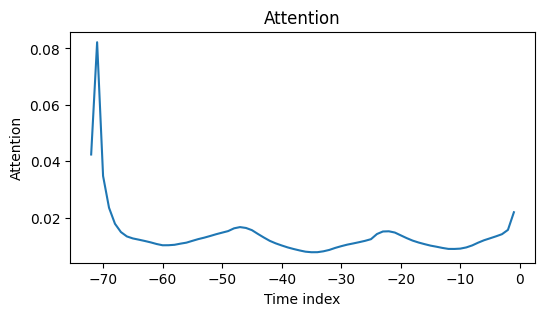

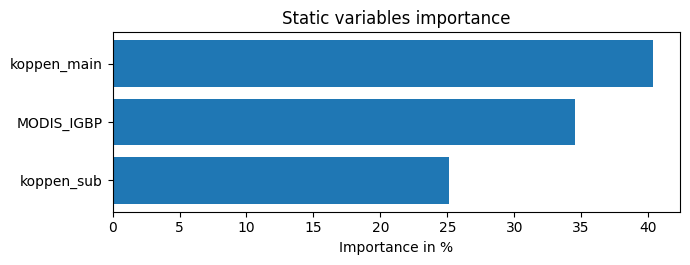

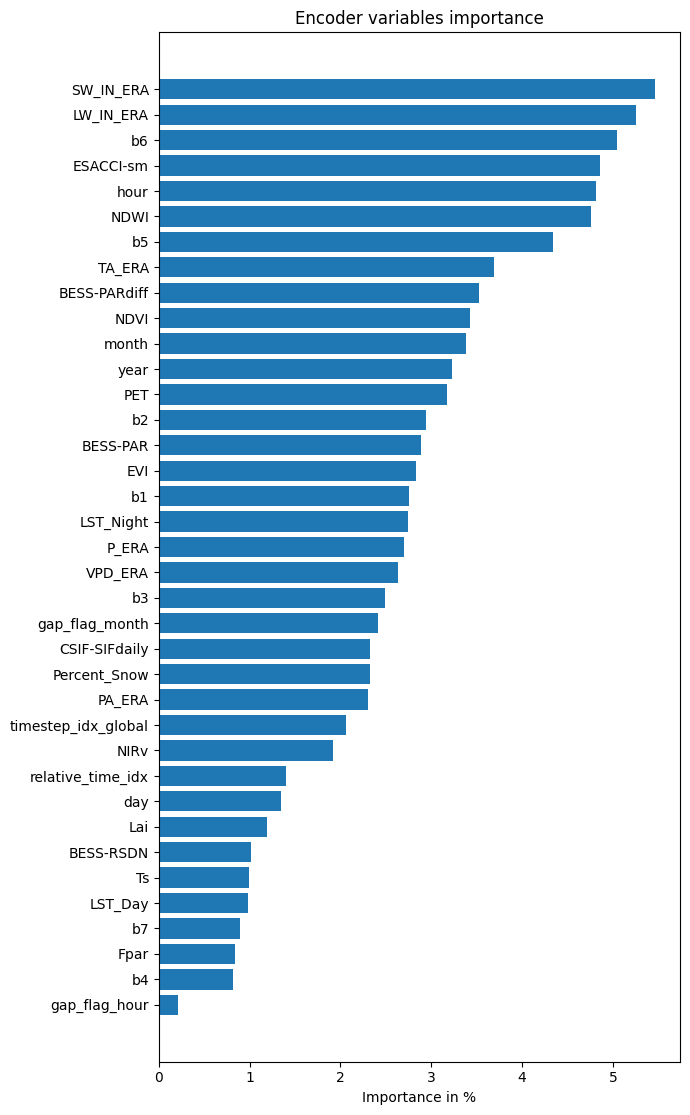

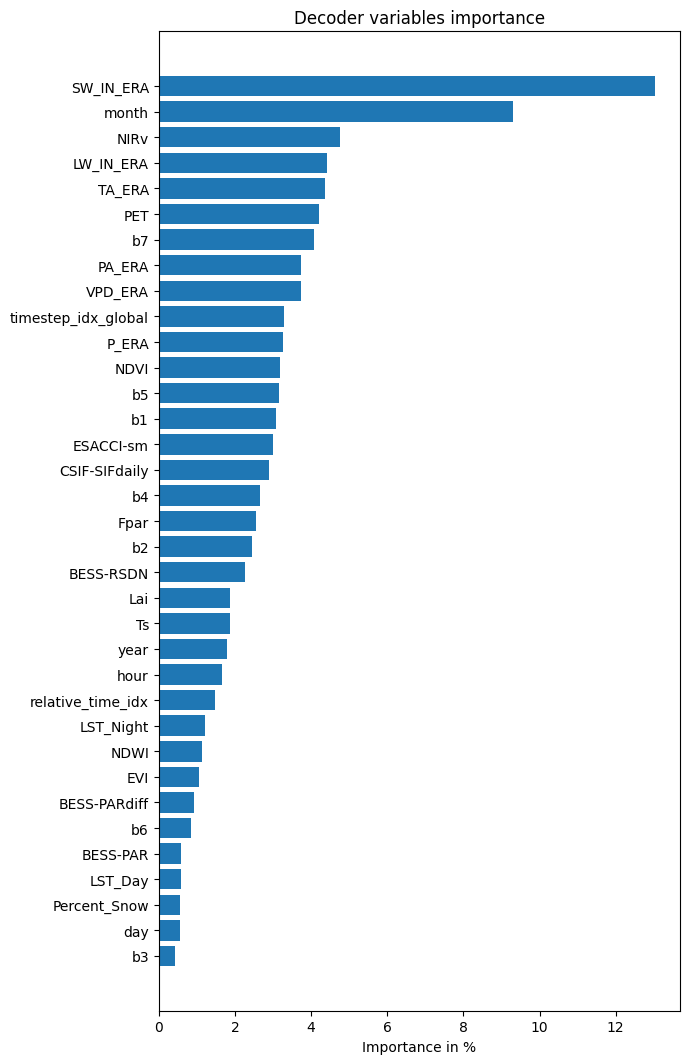

In [20]:
raw_preds = best_tft.predict(dataloader, mode="raw", return_x=False)
interpretation_sum = best_tft.interpret_output(raw_preds, reduction="sum")
best_tft.plot_interpretation(interpretation_sum)